# Forecasting Energy Load - Gefcom2014-e

In this notebook, we show how to use Deep4Cast to produce state-of-the art forecasts on the [Gefcom2014 data set](http://blog.drhongtao.com/2017/03/gefcom2014-load-forecasting-data.html).

The idea of this competition data set is to forecast hourly energy load a whole month into the future (~ 30 days * 24 hours) and to have those vector forecasts with well-calibrated uncertainties on a daily level. 

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt

from deep4cast.forecasters import Forecaster, VectorScaler
import deep4cast.models as models
import deep4cast.custom_metrics as metrics
import deep4cast.utils as utils

%matplotlib inline

Using TensorFlow backend.


# Parameters for network architecture

We first specify the parameters for the neural network forecasts, such as number of layers, etc. The architecture we will be using for forecasting is based on WaveNet.

In [2]:
horizon = 24*30 # forecasting horizon is hourly for 30 days
lag = horizon # the lookback window is the same as the horizon
filters = 64 # number of convolutional filters per layer in the neural net
num_layers = 2 # the neural network number of layers

# Data preparation

The data set consists of two time series, energy load and temperature, that we want to model. In addition, we build annually lagged variables.

In [3]:
# Loading the dataset and dropping unncecessary columns
df = pd.read_pickle('data/processed/GEFCom2014-e.pkl')

# Drop unnecessary fields
data = df.drop(['month', 'day', 'hour'], axis=1)
data = data.dropna()

# We have real-valued and categorial features and we need to make sure that we do the data 
# preparation for them correctly
real_values = ['load', 'temperature']
categorical = list(set(data.columns).difference(set(real_values)))

# Let's create lagged real features to include information about past year's behavior
lagged = data[real_values].shift(365*24-horizon)
lagged = lagged.rename(columns={column:column + '_yearly_lagged' for column in lagged.columns})
data = pd.concat([data, lagged], axis=1)
data = data.dropna()
data = data.reset_index(drop=True)

# Let's shift the holidays back by the horizon length for better forecasting on holidays
data['holiday'] = data['holiday'].shift(-horizon)

# Training & testing boundary
test_ind = data.index.where(data['time'] == dt.datetime(2014,1,1,0,0,0)).dropna().astype('int').values[0]

# Create a numpy array drop date columns
data_arr = data.drop(['time'], axis=1)
data_arr = np.expand_dims(data_arr.values, 0)

# Now we need to sequentialize the training and testing dataset
X_train, y_train = utils.sequentialize(data_arr[:,:test_ind,:], lag, horizon, targets=[0])
X_test, y_test = utils.sequentialize(data_arr[:,test_ind-lag:,:], lag, horizon, targets=[0])

# Rescale the datasets so that the neural networks can be fitted properly and stably
scaler = VectorScaler(targets=[0, 1, -2, -1])
scaler.fit_x(X_train)
scaler.fit_y(y_train)
X_train = scaler.transform_x(X_train)
X_test = scaler.transform_x(X_test)
y_train = scaler.transform_y(y_train)

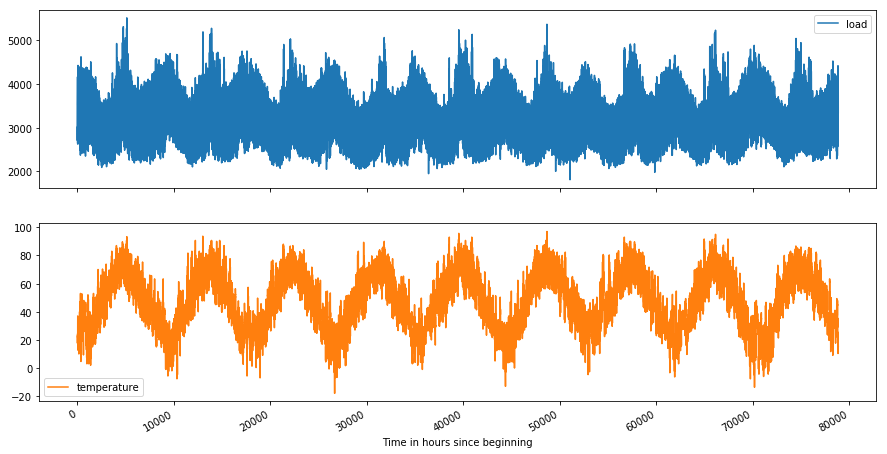

In [10]:
# Let plot the data to help our imagination
df[['load', 'temperature']].plot(subplots=True, figsize=(15, 8))
plt.xlabel('Time in hours since beginning')
plt.show()

# Modeling
The network architecture that we we are using in this example is based on ideas related to WaveNet by DeepMind (see references). We emplot the same architecture with a few modifications (e.g., a fully connected output layer for vectorial forecasts).
It turns out that we do not need many layers in this example to achieve state-of-the-art results, most likely because of the simple autoregressive nature of the data.

### WaveNet

![architecture](https://storage.googleapis.com/deepmind-live-cms/documents/BlogPost-Fig2-Anim-160908-r01.gif)


In many ways, a temporal convoluational architecture is among the simplest possible arhcitecures that we could employ using neural networks. In our approach, every layer has the same number of convoluational filters and used residual connections.

In [5]:
# This defines the model architecture
model = models.WaveNet(filters=filters, num_layers=num_layers)

# This sets up the forecaster
forecaster = Forecaster(model, lr=0.001, epochs=1)
forecaster.fit(X_train, y_train, verbose=1)

Epoch 1/1
60648/60648 [==============================] - 188s 3ms/step - loss: -1.1714


# Evaluation

Before any evaluation score can be calculated, we need to transform the output forecasts.

In [6]:
# Testing set evaluation
y_test_eval = y_test[::horizon] # Only need to evaluate every horizonth's step due to overlap
y_test_eval = np.reshape(y_test_eval, y_test_eval.shape[0]*y_test_eval.shape[1])
y_test_eval = np.atleast_2d(y_test_eval).T

# Build prediction time series using the inverse transform from the data preparation step
samples = forecaster.predict(X_test[::horizon,:,:])
samples = scaler.inverse_transform_y(samples)

# Let's concatenate the windowed outputs
test_samples = []
for i in range(samples.shape[1]):
    test_samples.append(samples[:,i,:,:])
test_samples = np.concatenate(test_samples, axis=1)
test_mean = np.mean(test_samples, axis=0)
test_lq = np.percentile(test_samples, q=5, axis=0)
test_uq = np.percentile(test_samples, q=95, axis=0)

# Test set days
test_dates = data.time[test_ind:test_mean.shape[0]+test_ind]

The original Gefcom2014 competition was evaluate using the [pinball loss function](https://www.lokad.com/pinball-loss-function-definition). Here, we calculate the symmetric MAPE, pinball loss, and empirical coverage for the test set.

SMAPE: 4.78%
Pinball Score: 56.64
Coverage: 


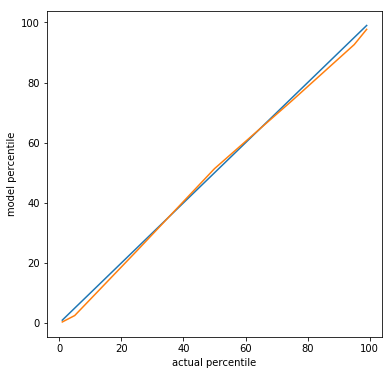

In [7]:
# Evaluate forecasts
test_smape = metrics.smape(test_samples, y_test_eval)
test_cov, test_perc = metrics.coverage(test_samples, y_test_eval)
test_pinball = metrics.pinball_loss(test_samples, y_test_eval)

print('SMAPE: {}%'.format(test_smape))
print('Pinball Score: {}'.format(test_pinball))
print('Coverage: ')

plt.figure(figsize=(6, 6))
plt.plot(test_perc, test_perc)
plt.plot(test_perc, test_cov)
plt.xlabel('actual percentile')
plt.ylabel('model percentile')

Let's have a closer look at what a forecast over a whole month looks like. We can use the model output to graph the mean, upper and lower confidence intervals, and some samples.

Text(0,0.5,'Load')

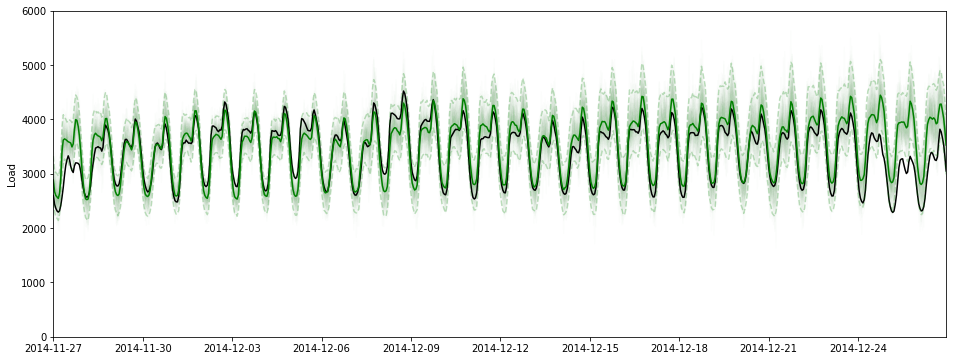

In [8]:
# We're printing the test set data and the predictions for the load data
plt.figure(figsize=(16, 6))

plt.plot(test_dates[-720:], test_samples[::20,-720:,0].T, 'g-', alpha=0.01)
plt.plot(test_dates[-720:], y_test_eval[-720:,0], 'k-')
plt.plot(test_dates[-720:], test_mean[-720:,0], 'g-')
plt.plot(test_dates[-720:], test_uq[-720:,0], 'g--', alpha=0.25)
plt.plot(test_dates[-720:], test_lq[-720:,0], 'g--', alpha=0.25)


plt.ylim([0, 6000])
plt.xlim([test_dates.values[[-720]], test_dates.values[-1]])

plt.ylabel('Load')

# References
[WaveNet Paper](https://arxiv.org/abs/1609.03499)

[Comparison of CNNs to RNNs for sequence modeling](https://arxiv.org/abs/1803.01271)

[Conditional time series forecasting with CNNs](https://arxiv.org/abs/1703.04691)